In [2]:
import sys
sys.path.insert(0, '/opt/homebrew/Cellar/pythia/8.309/lib')
import pythia8


from tqdm import tqdm
import pandas as pd
import numpy as np


mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 + pz ** 2) ** 0.5)) ** 0.5           #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats

In [3]:
from abc import ABC, abstractmethod

class AbstartcPythiaGenerator(ABC):

    def __init__(self, instructions: dict) -> None:
        super().__init__()

        self.pythia = pythia8.Pythia("", False)

        self.pythia.readString(f'Random:setSeed  = on')

        for inst, val in instructions.items():
        
            self.pythia.readString(f'{inst} = {val}')

    @abstractmethod
    def generate(self, n_events: int, random_state: int=None):
        if random_state is None:
            self.pythia.readString(f'Random:seed  = {np.random.randint(0, 90000000)}')
        else:
            self.pythia.readString(f'Random:seed  = {random_state}')
        self.pythia.init()

In [4]:
class Generator(AbstartcPythiaGenerator):

        def generate(self, n_events: int, random_state: int=None):
            super().generate(n_events, random_state)
            
            ID = []
            PT = []
            XF = []
            EE = []

            p1 = pythia8.Vec4(0.0, 0.0, 158.0, (158.0 ** 2 + mp ** 2) ** 0.5)
            p2 = pythia8.Vec4(0.0, 0.0, 0.0, mp)
            boost = pythia8.RotBstMatrix()
            boost.bstback(p1 + p2)
            
            for _ in tqdm(range(n_events)):

                if not self.pythia.next(): continue
                
                entries = self.pythia.event.size()

                for j in range(entries):

                    particle = self.pythia.event[j]

                    id = particle.id()
                    
                    if abs(int(id)) == 211 or abs(int(id)) == 321:

                        P_mu = particle.p()
                        P_mu.rotbst(boost)

                        pT = P_mu.pT()
                        xF = 2 * P_mu.pz() / root_s
                        E = P_mu.e()

                        ID.append(id)
                        PT.append(pT)
                        XF.append(xF)
                        EE.append(E)

            data = pd.DataFrame({'id': ID, 'pT': PT, 'xF': XF, 'E': EE})
            sigma = self.pythia.getSigmaTotal()

            return data, sigma

In [59]:
def xsect_calc(data, sigma, n_events, bins):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * \
            (data['xF'] < xF + dxF / 2) * \
            (data['pT'] > pT - dpT / 2) * \
            (data['pT'] < pT + dpT / 2)

        dn = np.sum(mask_for_bin)

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append(E.mean() * (sigma / n_events) * (dn / dp3) / norm)
        err.append(E.std() * (sigma / n_events) * (dn / dp3) / norm)

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, 0)

    return xsect, err

In [58]:
def chi_square(y_hat, y, y_hat_err, y_err):

    return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

def chi_square_fair(y_hat, y, y_hat_err, y_err):

    fairness = y_err ** 2 / y ** 2
    chi_square = (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

    return chi_square * fairness

In [79]:
def per_bin_metric_calc(xsect, err, bins, ref, metric):

    active_bins = []
    res = []

    for num, bin in enumerate(bins):

        mask = (ref['xF'] == bin[0]) * (ref['pT'] == bin[1])

        if np.sum(mask) != 0:

            active_bins.append(num)
            
            y = ref['xsect'][mask].values[0]
            y_hat = xsect[num]

            y_err = ref['error'][mask].values[0]
            y_hat_err = err[num]

            res.append(metric(y_hat, y,
                              y_hat_err, y_err))
            
    return res, active_bins

In [57]:
def get_score(n_events, data, sigma, ref, bins, metric):

    xsect, err = xsect_calc(data, sigma, n_events, bins)
    res, active_bins = per_bin_metric_calc(xsect, err, bins, ref, metric)
    
    return res, active_bins

In [9]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [10]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [11]:
ids = [211, 321, -211, -321]

refs = {}

for id in ids:
    
    refs[id] = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [350]:
inst = {
    'Print:quiet': 'on',

    'Beams:frameType': '2',

    'Beams:idA': '2212',
    'Beams:idB': '2212',

    'Beams:eA': '158',
    'Beams:eB': '0',

    'SoftQCD:all': 'on',

    'Tune:pp': '1',

    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on',

    'MultipartonInteractions:ecmRef': '1800',
    }

In [423]:
gen = Generator(inst)

In [424]:
def pipeline(n_events):

    data, sigma = gen.generate(n_events)   
    
    pp_data = data[data['id'] == 211]
    kp_data = data[data['id'] == 321]

    data.to_csv(f'{n_events}.csv', index=False)
    
    pp_res, pp_ab = get_score(n_events, pp_data,
                         sigma, refs[211], bins,
                         chi_square)
    
    kp_res, kp_ab = get_score(n_events, kp_data,
                         sigma, refs[321], bins,
                         chi_square)
    
    return pp_res, kp_res

In [425]:
stat = 10
ns = [3, 4, 5, 6, 7]

res_pi = {}
res_k = {}

In [ ]:
for n in ns:

    res_pi[n] = []
    res_k[n] = []

    print(f'Evuluate statistics for 10^{n} events:')
    
    for _ in range(stat):

        pi, k = pipeline(int(10 ** n))

        res_pi[n].append(pi)
        res_k[n].append(k)

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_pi[n]):.5}\n\
        STD: {(np.sum((np.std(res_pi[n], axis=0) ** 2)) ** 0.5) / len(res_pi[n][0]):.5}\n')

Evuluate statistics for 10^3 events:


100%|██████████| 1000/1000 [00:00<00:00, 9426.06it/s]


For 10^3 events
        Mean value: 7343.9
        STD: 1003.9

Evuluate statistics for 10^4 events:


100%|██████████| 10000/10000 [00:01<00:00, 9638.58it/s]


For 10^4 events
        Mean value: 973.39
        STD: 82.972

Evuluate statistics for 10^5 events:


100%|██████████| 100000/100000 [00:10<00:00, 9584.09it/s]


For 10^5 events
        Mean value: 354.66
        STD: 17.842

Evuluate statistics for 10^6 events:


100%|██████████| 1000000/1000000 [01:45<00:00, 9516.70it/s]


For 10^6 events
        Mean value: 301.55
        STD: 5.6157

Evuluate statistics for 10^7 events:


100%|██████████| 10000000/10000000 [17:21<00:00, 9605.27it/s]


For 10^7 events
        Mean value: 294.39
        STD: 1.7383



In [ ]:
print('pi-mesons')

for n in ns:

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_pi[n]):.5}\n\
        STD: {np.std(res_pi[n]):.5}\n')

pi-mesons
For 10^3 events
        Mean value: 7343.9
        STD: 1.8437e+04

For 10^4 events
        Mean value: 973.39
        STD: 1581.0

For 10^5 events
        Mean value: 354.66
        STD: 481.69

For 10^6 events
        Mean value: 301.55
        STD: 386.68

For 10^7 events
        Mean value: 294.39
        STD: 372.31



In [ ]:
print('K-mesons')

for n in ns:

    print(f'For 10^{n} events\n\
        Mean value: {np.mean(res_k[n]):.5}\n\
        STD: {np.std(res_k[n]):.5}\n')

K-mesons
For 10^3 events
        Mean value: 4121.2
        STD: 1.9331e+04

For 10^4 events
        Mean value: 596.66
        STD: 2053.5

For 10^5 events
        Mean value: 101.71
        STD: 155.97

For 10^6 events
        Mean value: 53.36
        STD: 52.648

For 10^7 events
        Mean value: 47.538
        STD: 41.35



In [ ]:
sample = np.random.choice(a=100, size=100, replace=False)

In [ ]:
z3 = np.array(res_pi[3])
z4 = np.array(res_pi[4])
z5 = np.array(res_pi[5])
z6 = np.array(res_pi[6])
z7 = np.array(res_pi[7])

In [ ]:
z3.mean(axis=0)[sample]

array([1.17788938e+02, 1.28444444e+02, 3.56371876e+03, 3.35022884e+02,
       1.60904783e+02, 6.60351467e+03, 8.25090595e+02, 1.28343743e+04,
       3.09556806e+04, 9.02352633e+02, 2.70857419e+02, 1.39981376e+02,
       5.77150274e+02, 1.43577762e+03, 7.18641529e+01, 3.24088895e+02,
       9.80582986e+01, 5.74553555e+03, 2.81873941e+04, 4.41188452e+01,
       3.08488767e+03, 5.48919184e+03, 2.82190662e+04, 4.81578793e+02,
       3.85431564e+02, 8.25671826e+03, 1.17011041e+02, 1.72601205e+02,
       1.65216538e+02, 2.83176020e+01, 5.11868532e+03, 2.19360117e+02,
       3.46636047e+03, 4.11254542e+02, 1.97240484e+01, 2.04081633e+02,
       1.73471275e+03, 2.96282462e+03, 5.38889463e+01, 2.22461745e+02,
       1.53816042e+04, 2.60224457e+02, 3.75021113e+02, 5.17292899e+01,
       2.79516602e+02, 1.66351369e+02, 6.04359882e+02, 8.54137693e+02,
       1.11615668e+04, 2.47275625e+02, 6.21530557e+01, 2.57968547e+03,
       2.18625515e+03, 4.08412099e+03, 1.71379386e+02, 9.13309030e+02,
      

In [ ]:
z3.std(axis=0)[sample]

array([1.42108547e-14, 2.84217094e-14, 8.46226319e+03, 0.00000000e+00,
       0.00000000e+00, 1.94178542e+04, 0.00000000e+00, 3.54562832e+04,
       9.25496542e+04, 0.00000000e+00, 0.00000000e+00, 2.84217094e-14,
       1.13686838e-13, 0.00000000e+00, 1.42108547e-14, 5.68434189e-14,
       1.42108547e-14, 1.31778622e+04, 5.59881346e+04, 7.10542736e-15,
       4.41764731e+03, 0.00000000e+00, 5.54867486e+04, 1.13686838e-13,
       0.00000000e+00, 2.18082591e+04, 2.84217094e-14, 0.00000000e+00,
       2.84217094e-14, 0.00000000e+00, 1.37484362e+04, 0.00000000e+00,
       9.61719752e+02, 0.00000000e+00, 3.55271368e-15, 0.00000000e+00,
       2.27373675e-13, 1.60419447e+03, 7.10542736e-15, 2.84217094e-14,
       2.63631070e+04, 5.68434189e-14, 0.00000000e+00, 1.42108547e-14,
       0.00000000e+00, 2.84217094e-14, 1.13686838e-13, 1.13686838e-13,
       3.03595495e+04, 5.68434189e-14, 0.00000000e+00, 5.06649305e+03,
       4.54747351e-13, 7.08063177e+03, 0.00000000e+00, 1.13686838e-13,
      

In [ ]:
z4.mean(axis=0)[sample]

array([ 117.78893794,  128.44444444,  510.27389064,  377.60714482,
        160.90478281,  139.9206716 ,  558.41952254,  817.84700503,
        105.79591837,  346.30935723,  269.68363495,  350.30518568,
        580.3300648 ,  709.24980926,   71.86415289,  269.65522079,
         98.05829863,  649.47136106,  205.16622155,  223.38820168,
        489.78578714, 1012.24329653,  439.37739937,  517.19377413,
        505.75819696,  297.36229031,  117.01104088,  172.60120494,
        165.21653778,   28.31760204,  440.14946851,  576.61092433,
        450.07017829,  411.25454152,   19.72404844, 2407.70077547,
       1162.44866052,  864.3906219 ,   53.88894628,  222.46174472,
        841.77566101,  260.22445675,  375.02111256,   51.72928994,
        351.81830722,  166.3513688 , 1128.68571057,  780.87347658,
        837.33438857,  316.64821968,   62.15305571,  308.69923674,
        872.79853848,  862.86502564,  240.7381187 , 1091.52421281,
        176.70849636,  579.48964535,  253.82288813,  312.81935

In [ ]:
z4.std(axis=0)[sample]

array([1.42108547e-14, 2.84217094e-14, 3.45344689e+02, 1.27752781e+02,
       0.00000000e+00, 2.70721735e+01, 3.31693369e+02, 3.95541399e+02,
       1.42108547e-14, 3.71946032e+02, 3.52135264e+00, 4.21149603e+02,
       9.53937150e+00, 5.96954543e+02, 1.42108547e-14, 8.31712006e+01,
       1.42108547e-14, 5.89462584e+02, 2.84217094e-14, 5.37808069e+02,
       4.59107648e+02, 1.02531291e+03, 9.40742080e+01, 4.00252452e+02,
       3.60979898e+02, 4.51670640e+02, 2.84217094e-14, 0.00000000e+00,
       2.84217094e-14, 0.00000000e+00, 2.21140627e+02, 1.07175242e+03,
       4.43375701e+02, 0.00000000e+00, 3.55271368e-15, 6.61085743e+03,
       7.21155478e+02, 7.34399624e+02, 7.10542736e-15, 2.84217094e-14,
       1.20286665e+03, 5.68434189e-14, 0.00000000e+00, 1.42108547e-14,
       1.10791361e+02, 2.84217094e-14, 1.57297749e+03, 2.19792650e+02,
       4.08810119e+02, 1.06572510e+02, 0.00000000e+00, 3.08452309e+02,
       7.56110781e+02, 7.20788321e+02, 2.08076199e+02, 2.02589045e+03,
      

In [ ]:
z5.mean(axis=0)[sample]

array([  63.73926758,   81.95323638,  196.06766662,  132.68340744,
         85.25252899,   61.92377092,  198.33671411,  326.49328536,
         87.76327105,  172.55517554,  107.09841996,   73.21367648,
        205.29503305,  379.18167559,   52.9914666 ,   82.41864587,
         38.78013493,  557.43841813,  111.56736325,   35.94923394,
        153.37934374, 1073.76819629,  278.13250174,  158.03043434,
        132.32621052,  408.29192981,   72.49995861,   91.27519636,
        115.70269719,   26.95456919,  131.78927825,   70.79721607,
        279.30043157,  331.22178765,   19.72404844,  144.7729506 ,
        348.00777951,  192.28390564,   53.88894628,   82.29806554,
        155.23979544,   84.37931085,  207.30525491,   36.32494134,
        113.28445248,   95.8288596 ,  270.42928407,  188.18538676,
        277.44975382,  112.10225561,   55.97216077,  193.82299945,
        699.19542838,  574.19456844,   81.76576038,   78.90826729,
         86.61772329,  166.96604697,  106.65680353,  134.43011

In [ ]:
z5.std(axis=0)[sample]

array([4.51087594e+01, 5.69624522e+01, 1.07051446e+02, 9.92877578e+01,
       5.22204805e+01, 3.51767902e+01, 8.01711657e+01, 2.13069036e+02,
       4.59770773e+01, 1.04360539e+02, 8.60844769e+01, 5.73201454e+01,
       1.96625346e+02, 2.08343061e+02, 2.91508868e+01, 9.48532094e+01,
       4.48235934e+01, 3.06232158e+02, 6.69372613e+01, 1.63392406e+01,
       1.35051453e+02, 5.48893353e+02, 1.75159815e+02, 8.39987659e+01,
       6.72766591e+01, 2.03624766e+02, 4.55387935e+01, 5.56360944e+01,
       7.56336627e+01, 2.09345283e+00, 9.08189907e+01, 7.79856035e+01,
       1.27921289e+02, 1.60067048e+02, 3.55271368e-15, 9.05960231e+01,
       1.83826946e+02, 1.15168504e+02, 7.10542736e-15, 7.62254915e+01,
       1.48247913e+02, 4.68250124e+01, 1.08583191e+02, 2.35306020e+01,
       1.06039117e+02, 3.52866104e+01, 1.59889348e+02, 1.47778920e+02,
       1.33322277e+02, 8.26286435e+01, 1.85426848e+01, 1.53256474e+02,
       2.66132232e+02, 2.81790755e+02, 6.43527380e+01, 7.90022103e+01,
      

In [ ]:
z6.mean(axis=0)[sample]

array([ 43.0109099 ,  61.53365349, 206.58177839, 102.82539944,
       103.89540718,  71.86349324, 187.10923463, 301.92831089,
        57.14536297, 112.56204634,  99.74755929,  61.18526861,
       146.94222204, 273.70531724,  29.91066253, 118.96201168,
        37.53837164, 397.30649238,  70.41206164,  23.35357421,
       119.26141582, 795.57592571, 162.66659432, 159.22131127,
       151.53798096, 291.52241586,  56.58663728,  57.62462266,
        95.88612999,  11.45182087, 107.71484961,  66.42191186,
       257.36521465, 220.15183862,  15.50212616,  79.05045501,
       329.07042128, 261.66244149,  36.90680336,  73.63200287,
       150.9390208 ,  90.87170567, 142.07706473,  26.5658653 ,
        80.25756164,  94.4638209 , 189.4697759 , 216.78554792,
       389.26278663, 100.98817765,  34.2208829 , 213.80310336,
       474.4670711 , 466.28968974,  51.19528503, 118.59002662,
        45.06045032, 167.66910925, 100.99620319, 122.30284544,
        50.19645959,  28.09107716, 380.48721717, 266.96

In [ ]:
z6.std(axis=0)[sample]

array([ 17.97340115,  28.31055053,  59.5197113 ,  47.29739569,
        19.61596158,  11.56333557,  43.85667356,  61.33855517,
        13.33375038,  52.9219182 ,  25.72018846,  14.32825648,
        40.45075356,  71.80520903,  18.51883298,  26.94368531,
        15.2319847 ,  78.48449357,  25.88610313,   9.45248223,
        44.2691326 , 156.23501053,  48.050919  ,  34.22648549,
        41.05890265,  65.40096195,  25.83309854,  33.69263016,
        45.84237763,   7.55771947,  26.17767053,  30.46798413,
        86.31901183, 101.00544742,   4.2225271 ,  48.66674677,
        57.66209078,  57.60300305,  14.36691016,  39.78434916,
        60.02245329,  29.51284446,  41.33276826,  11.5488436 ,
        19.7532913 ,  15.89208827,  71.56600605,  38.87503262,
        95.03677562,  26.936873  ,  10.73729033,  60.02749646,
        83.24621494,  60.47669686,  16.98983597,  45.88287002,
        23.2271921 ,  51.7324462 ,  16.52914183,  29.15312813,
        15.37530487,   6.11698393,  84.10814609,  60.71

In [ ]:
z7.mean(axis=0)[sample]

array([ 45.30435961,  51.75832186, 179.45317348,  83.71208621,
        87.45324762,  69.48610401, 175.91401891, 309.75227904,
        48.97206783, 108.92563589,  93.30563024,  57.509955  ,
       166.20163859, 301.55251146,  33.1624307 ,  92.74833734,
        41.57796241, 411.77612347,  68.58382576,  21.3985722 ,
       120.14693874, 840.16179778, 173.27417891, 131.46610466,
       120.28070838, 298.86084279,  56.92407775,  63.11858561,
        88.84142791,  12.6356654 , 125.48705389,  62.77073106,
       243.48080265, 172.39342135,  14.76153584,  83.88972271,
       348.97361324, 259.65180777,  33.72946315,  75.90184184,
       144.89876739, 101.14469082, 144.00756365,  30.77905454,
        87.5861098 ,  98.70903348, 188.10603389, 214.85045751,
       342.44162345,  93.25036882,  29.72498681, 192.15251326,
       502.42218508, 470.11790006,  60.25559263, 101.20691422,
        48.70257625, 158.13800991, 103.31136564, 137.85912944,
        50.55091695,  25.50571353, 400.92326488, 244.76

In [ ]:
z7.std(axis=0)[sample]

array([ 5.42905293,  5.04612157, 12.31075236, 17.02296957,  6.51438821,
        3.32971631, 12.95092967, 22.2015131 ,  5.26973972, 19.19271056,
        6.32191921,  6.66167606, 18.787205  , 22.37306631,  4.6073556 ,
        6.2725416 ,  5.98639399, 21.6382064 ,  9.42071038,  1.90755713,
       11.84260412, 40.9400763 , 16.37002093, 13.65794915, 13.14649735,
       22.60229851,  3.77916402,  9.51838371, 15.97989621,  1.88597427,
        7.83102687,  9.43842054, 18.87509812, 24.68421019,  1.9652874 ,
       14.02580346, 25.79544002, 24.70366835,  3.03054877, 13.20388487,
       12.15191042, 10.90022988, 14.91214838,  2.59387947, 10.54148489,
        5.10636495, 17.03361598, 15.15700861, 32.12466429, 10.286712  ,
        3.76848143, 15.63795085, 23.73500155, 31.29548295,  5.89180605,
       11.84262336,  3.54819014, 15.75625854,  8.90559509,  6.45811968,
        5.00371878,  1.23517749, 26.73836447, 14.48635769, 18.04325421,
       10.0737193 ,  8.57711527, 11.81290456, 13.88761027,  5.65

In [ ]:
(z6.mean(axis=0) - z7.mean(axis=0)) / z6.std(axis=0)

array([ 0.36832101, -0.15664044,  0.42265333,  0.1753903 , -0.26520449,
       -0.1755925 ,  0.41871794, -0.36481482,  0.22115682, -0.30208612,
        0.4810152 , -0.1400655 ,  0.53954032, -0.26712742,  0.61297796,
        0.29592854,  0.15367227,  0.18274165, -0.02305368, -0.16306127,
        0.17086027,  0.25650808, -0.12760243, -0.01306233, -0.38159278,
        0.00180844, -0.0878407 ,  0.47283011, -0.09943684,  0.34528935,
        0.4402663 , -0.3710039 , -0.1568044 ,  0.07062615, -0.0340296 ,
       -0.53327811, -0.533606  ,  0.75390204, -0.05705357,  0.45557437,
        0.28088366,  0.81092774,  0.15127084,  0.97290605,  0.19788728,
        0.25046197,  0.27078517, -0.22075716, -0.04670626, -0.34808523,
        0.11983664,  0.28725713,  0.20682419, -0.16644559, -0.0187871 ,
       -0.67890702, -0.43318031,  0.18287399, -0.31969416,  0.05607799,
        0.1393785 ,  0.40410921,  0.76127881,  0.61395066,  0.25526824,
        0.36067788,  0.0497772 ,  0.45579194, -0.06330059, -0.18

In [ ]:
gen = Generator(instructions=inst)

------

------

Генерируем 10 миллионов столкновений

In [351]:
gen = Generator(instructions=inst)

In [65]:
N = int(1e7)

In [352]:
data, sigma = gen.generate(n_events=N, random_state=13)

100%|██████████| 10000000/10000000 [17:51<00:00, 9335.79it/s]


In [353]:
data.to_csv('data/data.csv', index=False)
file = open('data/sigma.txt', 'w')
file.write(f'{sigma}')
file.close()

In [66]:
data = pd.read_csv('data/data.csv')
sigma = float(open('data/sigma.txt', 'r').readline())

In [67]:
data = data[data.id == 211]

Считаем сечение старым методом

In [61]:
def xsect_calc(data, sigma, n_events, bins):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * \
            (data['xF'] < xF + dxF / 2) * \
            (data['pT'] > pT - dpT / 2) * \
            (data['pT'] < pT + dpT / 2)

        dn = np.sum(mask_for_bin)

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append(E.mean() * (sigma / n_events) * (dn / dp3) / norm)
        err.append(E.std() * (sigma / n_events) * (dn / dp3) / norm)

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, 0)

    return xsect, err

In [76]:
def get_score(n_events, data, sigma, ref, bins, metric):

    xsect, err = xsect_calc(data, sigma, n_events, bins)
    res, active_bins = per_bin_metric_calc(xsect, err, bins, ref, metric)
    
    return res

In [63]:
def chi_square(y_hat, y, y_hat_err, y_err):

    return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

In [64]:
frac = np.linspace(0.1, 1, 20)

In [374]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(20)):

        res_for_f.append(
            get_score(int(N * f),
                      data.sample(frac=f),
                      sigma, refs[211],
                      bins, chi_square)
        )

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 20/20 [05:19<00:00, 15.97s/it]


In [375]:
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

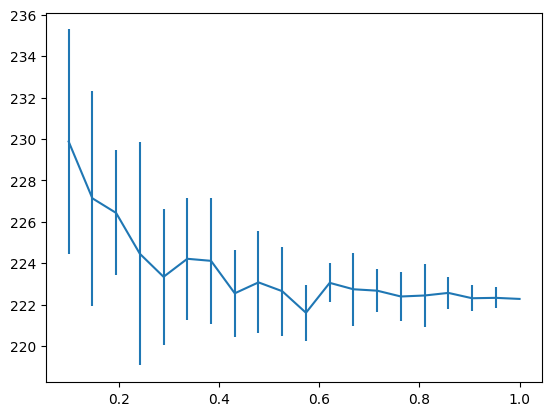

In [376]:
plt.errorbar(frac, res, yerr=err)

Будем считать не среднюю энергию, а брать значение центра бина

In [386]:
def xsect_calc_mod(data, sigma, n_events, bins):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * \
            (data['xF'] < xF + dxF / 2) * \
            (data['pT'] > pT - dpT / 2) * \
            (data['pT'] < pT + dpT / 2)

        dn = np.sum(mask_for_bin)

        dp3 = dxF * 2 * pT * dpT

        E = ((xF * root_s / 2) ** 2 + pT ** 2 + 0.13957 ** 2) ** 0.5

        xsect.append(E * (sigma / n_events) * (dn / dp3) / norm)
        err.append(E * (sigma / n_events) * (dn / dp3) / norm)

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, 0)

    return xsect, err

def get_score_mod(n_events, data, sigma, ref, bins, metric):

    xsect, err = xsect_calc_mod(data, sigma, n_events, bins)
    res, active_bins = per_bin_metric_calc(xsect, err, bins, ref, metric)
    
    return res

In [381]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(20)):

        res_for_f.append(np.mean(
            get_score_mod(int(N * f),
                      data.sample(frac=f),
                      sigma, refs[211],
                      bins, chi_square)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 20/20 [04:47<00:00, 14.39s/it]


<ErrorbarContainer object of 3 artists>

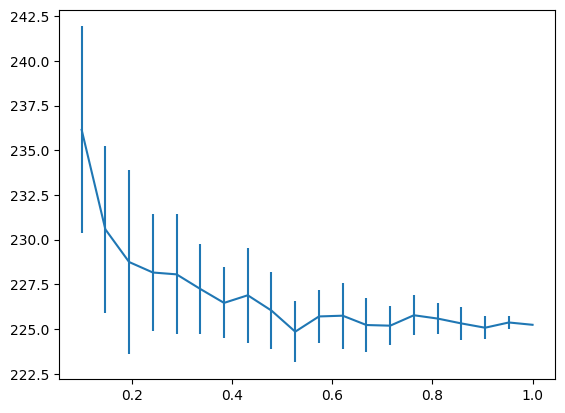

In [383]:
plt.errorbar(frac, res, yerr=err)

In [401]:
score7_per_bin = get_score_mod(N,
                      data,
                      sigma, refs[211],
                      bins, chi_square)

In [462]:
def sign_rel(f, itr=100):

    res = []

    for _ in tqdm(range(itr)):

        score_per_bin_1 = get_score_mod(int(N * f),
                    data.sample(frac=f),
                    sigma, refs[211],
                    bins, chi_square)

        res.append(((np.array(score_per_bin_1) - np.array(score7_per_bin)) < 0).sum() / \
                ((np.array(score_per_bin_1) - np.array(score7_per_bin)) > 0).sum())
        
    return res

In [463]:
res = sign_rel(0.01, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

0.71525 ± 0.083228


In [464]:
res = sign_rel(0.05, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]

0.87533 ± 0.10199


In [465]:
res = sign_rel(0.1, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [03:38<00:00,  2.19s/it]

0.89913 ± 0.10553


In [487]:
def sign_rel_rev(f, itr=100):

    res = []

    for _ in tqdm(range(itr)):

        score_per_bin_1 = get_score_mod(int(N * f),
                    data.sample(frac=f),
                    sigma, refs[211],
                    bins, chi_square)

        res.append(((np.array(score7_per_bin) - np.array(score_per_bin_1)) < 0).sum() / \
                ((np.array(score7_per_bin) - np.array(score_per_bin_1)) > 0).sum())
        
    return res

In [488]:
res = sign_rel_rev(0.01, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

1.434 ± 0.17119


In [489]:
res = sign_rel_rev(0.05, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

1.1648 ± 0.12614


In [490]:
res = sign_rel_rev(0.1, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [04:14<00:00,  2.55s/it]

1.1163 ± 0.14542


In [491]:
def sign_rel_id(f, itr=100):

    res = []

    for _ in tqdm(range(itr)):

        score_per_bin_1 = get_score_mod(int(N * f),
                    data.sample(frac=f),
                    sigma, refs[211],
                    bins, chi_square)
        
        score_per_bin_2 = get_score_mod(int(N * f),
                    data.sample(frac=f),
                    sigma, refs[211],
                    bins, chi_square)

        res.append(((np.array(score_per_bin_1) - np.array(score_per_bin_2)) < 0).sum() / \
                ((np.array(score_per_bin_1) - np.array(score_per_bin_2)) > 0).sum())
        
    return res

def sign_rel_id_rev(f, itr=100):

    res = []

    for _ in tqdm(range(itr)):

        score_per_bin_1 = get_score_mod(int(N * f),
                    data.sample(frac=f),
                    sigma, refs[211],
                    bins, chi_square)
        
        score_per_bin_2 = get_score_mod(int(N * f),
                    data.sample(frac=f),
                    sigma, refs[211],
                    bins, chi_square)

        res.append(((np.array(score_per_bin_2) - np.array(score_per_bin_1)) < 0).sum() / \
                ((np.array(score_per_bin_2) - np.array(score_per_bin_1)) > 0).sum())
        
    return res

In [492]:
res = sign_rel_id(0.01, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [02:50<00:00,  1.71s/it]

1.0053 ± 0.13286


In [493]:
res = sign_rel_id(0.05, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [04:49<00:00,  2.90s/it]

1.0095 ± 0.1287


In [494]:
res = sign_rel_id(0.1, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [08:09<00:00,  4.89s/it]

0.99731 ± 0.11361


In [495]:
res = sign_rel_id_rev(0.01, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [02:50<00:00,  1.70s/it]

0.98555 ± 0.12093


In [496]:
res = sign_rel_id_rev(0.05, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [04:52<00:00,  2.93s/it]

0.99761 ± 0.12866


In [497]:
res = sign_rel_id_rev(0.1, 100)
print(f'{np.mean(res):1.5} ± {np.std(res):1.5}')

100%|██████████| 100/100 [08:22<00:00,  5.03s/it]

1.0005 ± 0.11276


In [468]:
for i in range(10):

    data, sigma = gen.generate(n_events=N, random_state=i + 100)
    data.to_csv(f'data/data_{i}.csv', index=False)
    file = open(f'data/sigma_{i}.txt', 'w')
    file.write(f'{sigma}')
    file.close()

100%|██████████| 10000000/10000000 [17:25<00:00, 9568.62it/s]


In [470]:
res = []

for i in tqdm(range(10)):

    data = pd.read_csv(f'data/data_{i}.csv')
    sigma = float(open(f'data/sigma_{i}.txt', 'r').readline())

    res.append(get_score_mod(N,
                    data[data['id'] == 211],
                    sigma, refs[211],
                    bins, chi_square))

100%|██████████| 10/10 [08:00<00:00, 48.07s/it]


In [484]:
print(f'{np.mean(res):1.5} ± {np.std(np.mean(res, axis=1)):1.5}')

224.23 ± 2.0155


In [30]:
def xsect_calc_mod2(data, sigma, n_events, bins):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (np.abs(data['xF']) > xF - dxF / 2) * \
            (np.abs(data['xF']) < xF + dxF / 2) * \
            (np.abs(data['pT']) > pT - dpT / 2) * \
            (np.abs(data['pT']) < pT + dpT / 2)

        dn = np.sum(mask_for_bin)

        dp3 = dxF * 2 * pT * dpT

        E = ((xF * root_s / 2) ** 2 + pT ** 2 + 0.13957 ** 2) ** 0.5

        xsect.append(E * (sigma / n_events) * (dn / dp3) / norm)
        err.append(E * (sigma / n_events) * (dn / dp3) / norm / dn ** 0.5)

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), err, np.inf)

    return xsect, err

def get_score_mod2(n_events, data, sigma, ref, bins, metric):

    xsect, err = xsect_calc_mod2(data, sigma, n_events, bins)
    res, active_bins = per_bin_metric_calc(xsect, err, bins, ref, metric)
    
    return res

In [506]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(20)):

        res_for_f.append(np.mean(
            get_score_mod2(int(N * f),
                      data.sample(frac=f),
                      sigma, refs[211],
                      bins, chi_square)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 20/20 [16:22<00:00, 49.11s/it]


<ErrorbarContainer object of 3 artists>

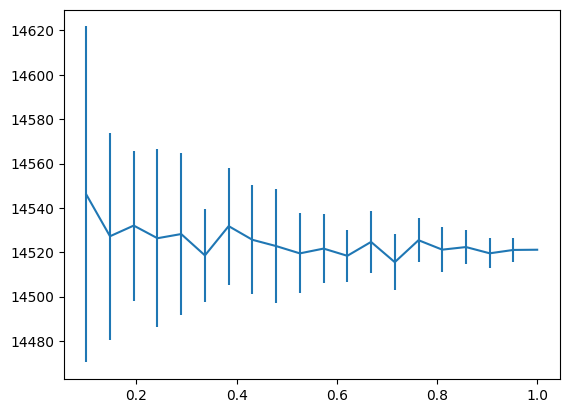

In [507]:
plt.errorbar(frac, res, yerr=err)

In [519]:
class Generator_mod(AbstartcPythiaGenerator):

        def generate(self, n_events: int, random_state: int=None):
            super().generate(n_events, random_state)
            
            ID = []
            PT = []
            XF = []
            EE = []

            p1 = pythia8.Vec4(0.0, 0.0, 158.0, (158.0 ** 2 + mp ** 2) ** 0.5)
            p2 = pythia8.Vec4(0.0, 0.0, 0.0, mp)
            boost = pythia8.RotBstMatrix()
            boost.bstback(p1 + p2)
            
            for _ in tqdm(range(n_events)):

                if not self.pythia.next(): continue
                
                entries = self.pythia.event.size()

                for j in range(entries):

                    particle = self.pythia.event[j]

                    id = particle.id()
                    
                    if ((int(id) == 211) * (particle.isFinal())):

                        P_mu = particle.p()
                        P_mu.rotbst(boost)

                        pT = P_mu.pT()
                        xF = 2 * P_mu.pz() / root_s
                        E = P_mu.e()

                        ID.append(id)
                        PT.append(pT)
                        XF.append(xF)
                        EE.append(E)

            data = pd.DataFrame({'id': ID, 'pT': PT, 'xF': XF, 'E': EE})
            sigma = self.pythia.getSigmaTotal()

            return data, sigma

In [520]:
gen_mod = Generator_mod(inst)
data6_mod, sigma6_mod = gen.generate(int(1e6), random_state=13)

100%|██████████| 1000000/1000000 [01:44<00:00, 9593.62it/s]


In [522]:
np.mean(get_score_mod(int(1e6),
                    data6_mod[data6_mod.id == 211],
                    sigma6_mod, refs[211],
                    bins, chi_square))

234.19333566343363

In [12]:
data = pd.read_csv('data/data.csv')
sigma = float(open('data/sigma.txt', 'r').readline())

In [33]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(10)):

        res_for_f.append(np.mean(
            get_score(int(N * f),
                      data[data.id == 211].sample(frac=f),
                      sigma, refs[211][0:1],
                      bins, chi_square)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 10/10 [02:46<00:00, 16.62s/it]


<ErrorbarContainer object of 3 artists>

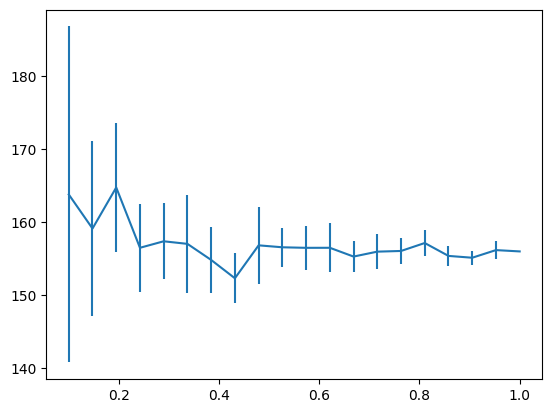

In [34]:
import matplotlib.pyplot as plt
plt.errorbar(frac, res, yerr=err)

In [35]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(10)):

        res_for_f.append(np.mean(
            get_score(int(N * f),
                      data[data.id == 211].sample(frac=f),
                      sigma, refs[211][10:11],
                      bins, chi_square)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 10/10 [02:46<00:00, 16.70s/it]


<ErrorbarContainer object of 3 artists>

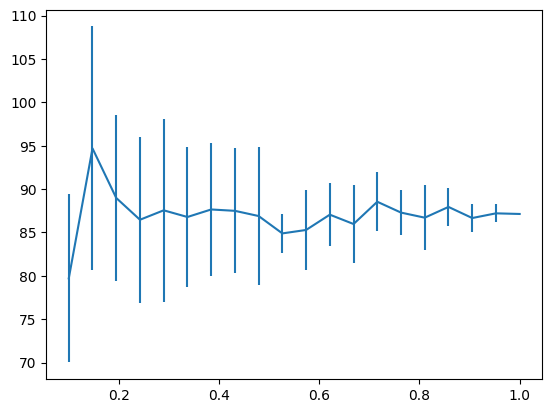

In [36]:
import matplotlib.pyplot as plt
plt.errorbar(frac, res, yerr=err)

In [68]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(10)):

        res_for_f.append(np.mean(
            get_score(int(N * f),
                      data[data.id == 211].sample(frac=f),
                      sigma, refs[211],
                      bins[0:130], chi_square)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


<ErrorbarContainer object of 3 artists>

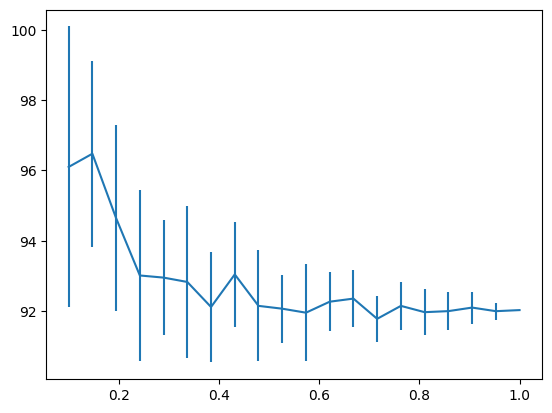

In [69]:
import matplotlib.pyplot as plt
plt.errorbar(frac, res, yerr=err)

In [47]:
def xsect_calc_mod3(data, sigma, n_events, bins):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * \
            (data['xF'] < xF + dxF / 2) * \
            (data['pT'] > pT - dpT / 2) * \
            (data['pT'] < pT + dpT / 2)

        dn = np.sum(mask_for_bin)

        dp3 = dxF * 2 * pT * dpT

        E = ((xF * root_s / 2) ** 2 + pT ** 2 + 0.13957 ** 2) ** 0.5

        xsect.append(E * (sigma / n_events) * (dn / dp3) / norm)
        err.append(dn)

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), np.inf, xsect / np.array(err) ** 0.5)

    return xsect, err

def get_score_mod3(n_events, data, sigma, ref, bins, metric):

    xsect, err = xsect_calc_mod3(data, sigma, n_events, bins)
    res, active_bins = per_bin_metric_calc(xsect, err, bins, ref, metric)
    
    return res

In [48]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(10)):

        res_for_f.append(np.mean(
            get_score_mod3(int(N * f),
                      data[data.id == 211].sample(frac=f),
                      sigma, refs[211],
                      bins, chi_square)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_44504/2757570417.py:29: RuntimeWarning: invalid value encountered in divide
  err = np.where(np.isnan(err), np.inf, xsect / np.array(err) ** 0.5)
100%|██████████| 10/10 [02:32<00:00, 15.28s/it]


<ErrorbarContainer object of 3 artists>

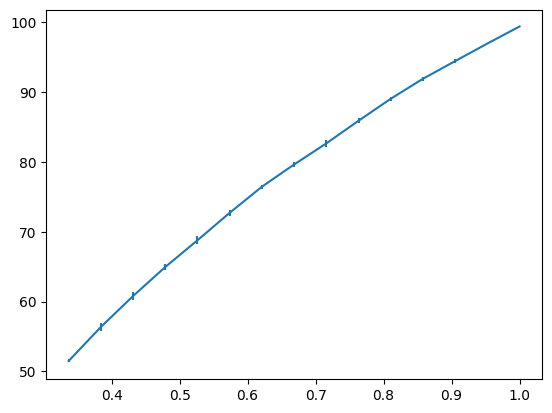

In [49]:
import matplotlib.pyplot as plt
plt.errorbar(frac, res, yerr=err)

In [80]:
res = []
err = []

for f in frac:

    res_for_f = []

    for _ in tqdm(range(10)):

        res_for_f.append(np.mean(
            get_score(int(N * f),
                      data[data.id == 211].sample(frac=f),
                      sigma, refs[211],
                      bins, chi_square_fair)
        ))

    res.append(np.mean(res_for_f))
    err.append(np.std(res_for_f))
        

100%|██████████| 10/10 [02:43<00:00, 16.34s/it]


Text(0, 0.5, '$(1 - \\hat{f}/f)^2$')

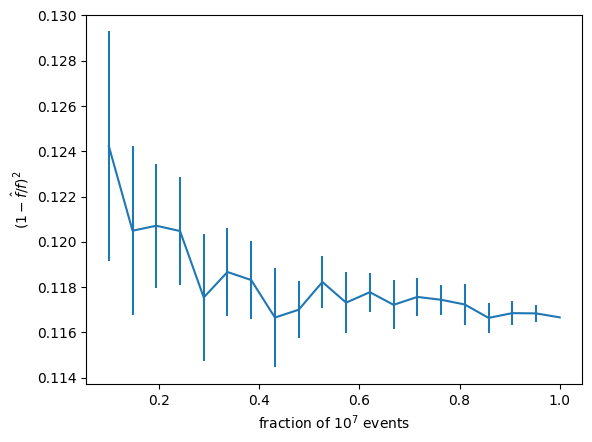

In [84]:
import matplotlib.pyplot as plt
plt.errorbar(frac, res, yerr=err)
plt.xlabel('fraction of $10^7$ events')
plt.ylabel('$(1 - \hat{f}/f)^2$')